In [1]:
%load_ext autoreload
%autoreload 2

Cell 1 — Setup

In [2]:
import os
import sys
import json
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Robust project root resolver
def find_project_root(start: Path) -> Path:
    start = start.resolve()
    for p in [start] + list(start.parents):
        if (p / 'configs' / 'base.yaml').exists() and (p / 'src').exists():
            return p
    raise FileNotFoundError("Could not locate project root")

PROJECT_ROOT = find_project_root(Path.cwd())
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.data.load import load_yaml, load_all_sources, add_broad_category
from src.models.classifier import load_classifier, prepare_text_and_labels

# Define the experiments to analyze
EXPERIMENTS_TO_ANALYZE = [
    'tfidf_logreg_basic',
    'tfidf_logreg_clean',
    'bow_logreg_clean',
    'tfidf_svm_clean',
    'tfidf_nb_clean',
    'tfidf_svm_bigrams'
]

RESULTS_BASE_DIR = PROJECT_ROOT / 'experiments' / 'results'
print(f'Project Root: {PROJECT_ROOT}')
print('Experiments to analyze:', EXPERIMENTS_TO_ANALYZE)
print('Results base dir:', RESULTS_BASE_DIR)

from src.data.load import load_yaml, load_all_sources, add_broad_category
from src.models.classifier import train_text_classifier
from src.models.evaluation import evaluate_classifier


2025-12-18 21:33:36.990841: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-18 21:33:37.155601: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-18 21:33:39.495522: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Project Root: /home/spark/NUST/Semester 5/Data Mining/Project
Experiments to analyze: ['tfidf_logreg_basic', 'tfidf_logreg_clean', 'bow_logreg_clean', 'tfidf_svm_clean', 'tfidf_nb_clean', 'tfidf_svm_bigrams']
Results base dir: /home/spark/NUST/Semester 5/Data Mining/Project/experiments/results


Cell 2 — Load data + mapping + confusion matrix

INFO:src.data.load:Loading source pakistan_today from /home/spark/NUST/Semester 5/Data Mining/Project/data/raw/pakistan_today(full-data).csv (encoding=utf-8)
INFO:src.data.load:Loading source tribune from /home/spark/NUST/Semester 5/Data Mining/Project/data/raw/tribune(full-data).csv (encoding=latin1)
INFO:src.data.load:Loading source dawn from /home/spark/NUST/Semester 5/Data Mining/Project/data/raw/dawn (full-data).csv (encoding=latin1)
INFO:src.data.load:Loading source daily_times from /home/spark/NUST/Semester 5/Data Mining/Project/data/raw/daily_times(full-data).csv (encoding=utf-8)
INFO:src.data.load:Loading preprocessed business_reorder from /home/spark/NUST/Semester 5/Data Mining/Project/data/interim/business_reorder_clean.parquet
INFO:src.data.load:Filtered invalid sources: (625905, 7) -> (624642, 7)
INFO:src.data.load:Combined dataset shape: (624642, 7)
INFO:src.data.load:Sampling up to 10000 rows per source (__file__ column).
/home/spark/NUST/Semester 5/Data Mining/Project/s

---------------Processing experiment: tfidf_logreg_basic ---------------
Preparing data for predictions...
Generating confusion matrix...
---------------Processing experiment: tfidf_logreg_clean ---------------
Preparing data for predictions...
Generating confusion matrix...
---------------Processing experiment: bow_logreg_clean ---------------
Preparing data for predictions...
Generating confusion matrix...
---------------Processing experiment: tfidf_svm_clean ---------------
Preparing data for predictions...
Generating confusion matrix...
---------------Processing experiment: tfidf_nb_clean ---------------
Preparing data for predictions...
Generating confusion matrix...
---------------Processing experiment: tfidf_svm_bigrams ---------------
Preparing data for predictions...
Generating confusion matrix...


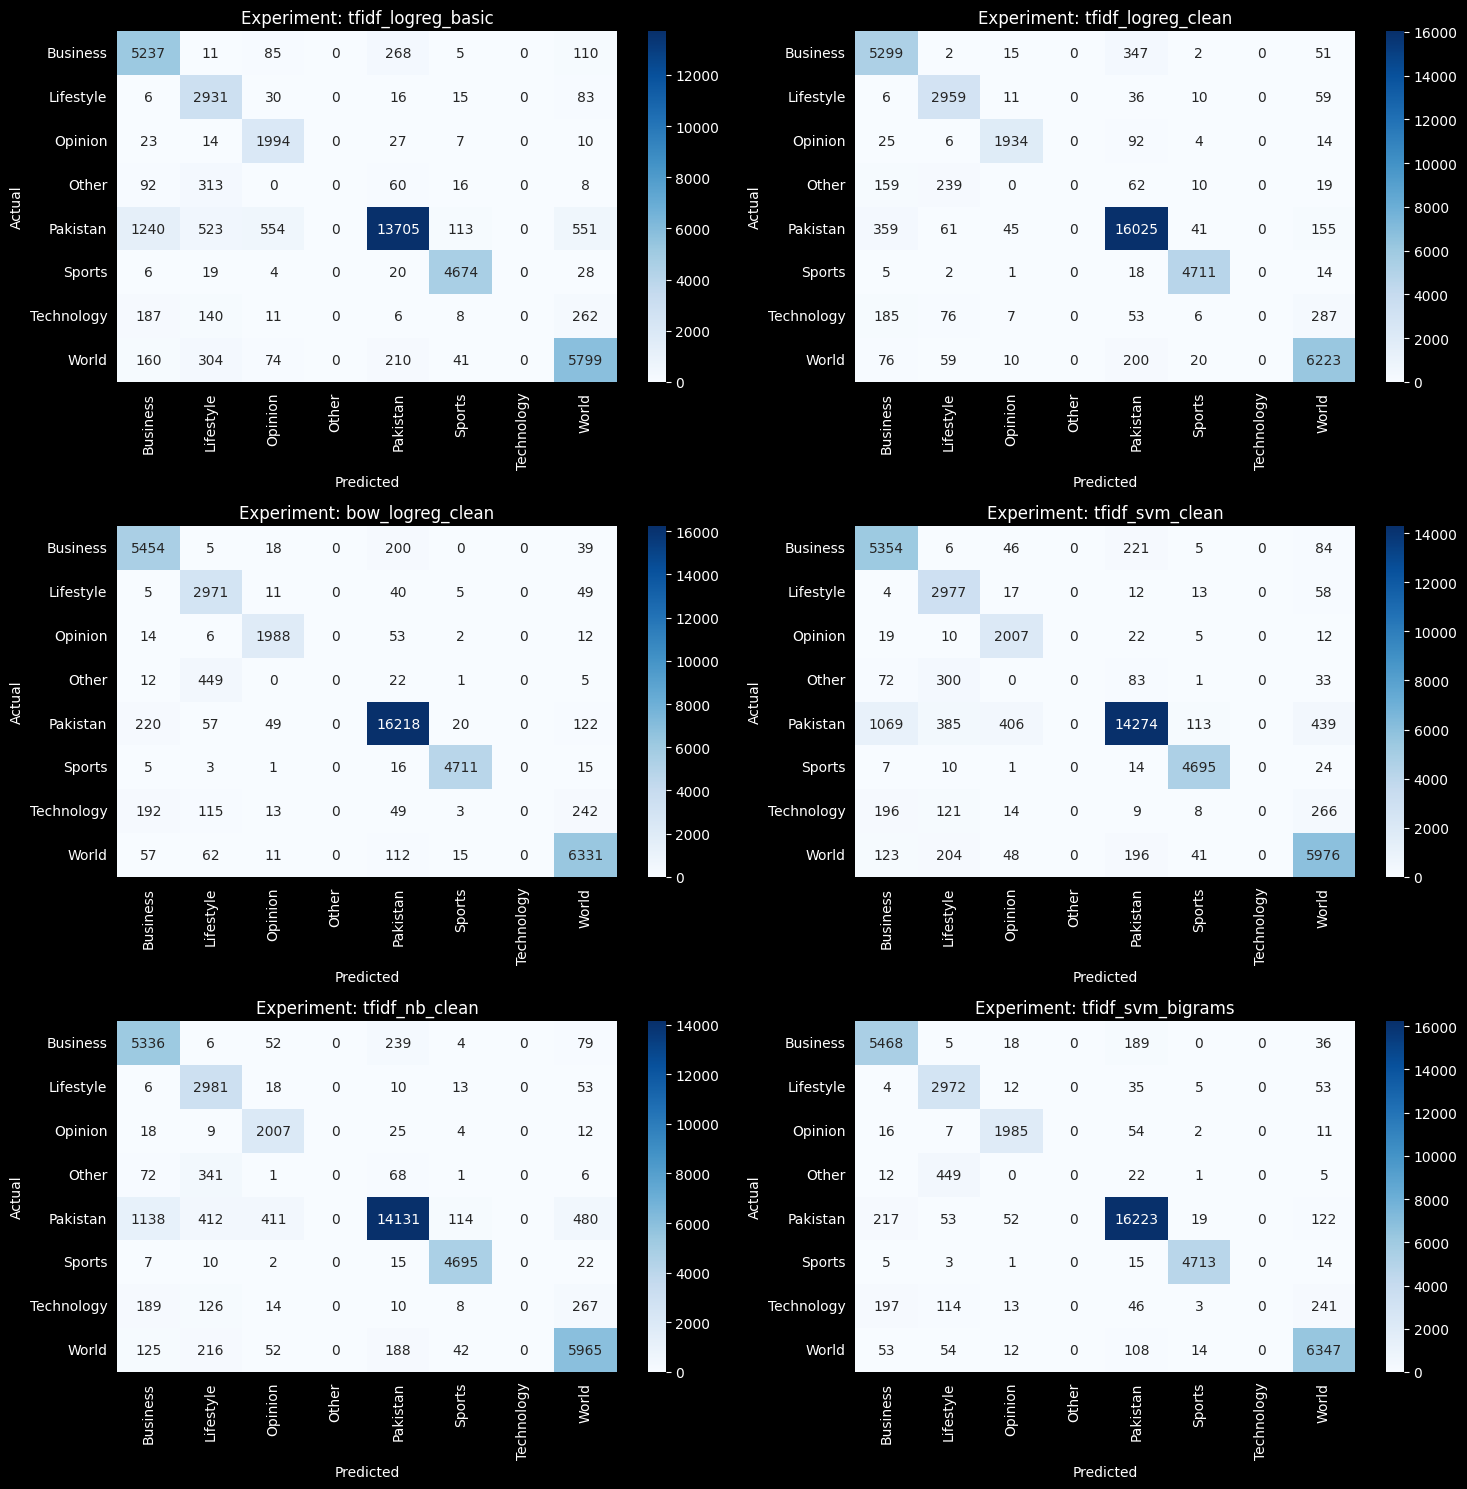

In [3]:
# We need the data to run predictions for the confusion matrices
base_cfg = load_yaml(PROJECT_ROOT / 'configs' / 'base.yaml')
df_raw = load_all_sources(base_cfg, root=PROJECT_ROOT)
df = add_broad_category(df_raw, base_cfg, root=PROJECT_ROOT)

num_exps = len(EXPERIMENTS_TO_ANALYZE)
cols = 2
rows = (num_exps + 1) // cols

plt.figure(figsize=(15, 5 * rows))

for i, exp_id in enumerate(EXPERIMENTS_TO_ANALYZE):
    exp_dir = RESULTS_BASE_DIR / exp_id
    config_path = PROJECT_ROOT / 'configs' / f"{exp_id}.yaml"

    print('---------------Processing experiment:', exp_id, '---------------')

    if not exp_dir.exists() or not config_path.exists():
        print(f"Skipping {exp_id}: missing experiment dir or config.")
        continue

    # Load specific config and model
    cfg = load_yaml(config_path)
    model = load_classifier(cfg, root=PROJECT_ROOT)

    # Prepare X, y for this specific config's preprocessing
    print('Preparing data for predictions...')
    X_text, y_true = prepare_text_and_labels(df, cfg)
    y_pred = model.predict(X_text)

    # Generate Matrix
    print('Generating confusion matrix...')
    labels = sorted(list(set(y_true)))
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    # Plot
    plt.subplot(rows, cols, i + 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(f"Experiment: {exp_id}")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

plt.tight_layout()
plt.show()

Cell 3 — Train and evaluate

In [4]:
# 1. Detect the winner from the record file created in Notebook 03
best_run_path = RESULTS_BASE_DIR / 'best_model_run.txt'
if best_run_path.exists():
    with open(best_run_path, 'r') as f:
        best_run_line = f.readline()
        BEST_EXP_ID = best_run_line.split(': ')[1].strip()
else:
    BEST_EXP_ID = EXPERIMENTS_TO_ANALYZE[-1] # Fallback to last if file missing

print(f"--- Deep Error Analysis for Winner: {BEST_EXP_ID} ---")

# 2. Load the best model and its specific data
best_cfg = load_yaml(PROJECT_ROOT / 'configs' / f"{BEST_EXP_ID}.yaml")
best_model = load_classifier(best_cfg, root=PROJECT_ROOT)

X_text, y_true = prepare_text_and_labels(df, best_cfg)
y_pred = best_model.predict(X_text)

# 3. Create an Error DataFrame for inspection
error_df = df.copy()
error_df['predicted'] = y_pred
error_df['actual'] = y_true
error_df['is_correct'] = error_df['predicted'] == error_df['actual']

# Show only misclassifications
misclassified = error_df[error_df['is_correct'] == False]
print(f"Total Misclassified: {len(misclassified)} out of {len(df)}")

# Display top 10 most frequent confusions
confusion_counts = misclassified.groupby(['actual', 'predicted']).size().reset_index(name='count')
print("\nTop 10 Most Common Error Pairs:")
print(confusion_counts.sort_values('count', ascending=False).head(10))

--- Deep Error Analysis for Winner: tfidf_svm_bigrams ---
Total Misclassified: 2292 out of 40000

Top 10 Most Common Error Pairs:
        actual  predicted  count
15       Other  Lifestyle    449
34  Technology      World    241
19    Pakistan   Business    217
29  Technology   Business    197
2     Business   Pakistan    189
23    Pakistan      World    122
30  Technology  Lifestyle    114
38       World   Pakistan    108
36       World  Lifestyle     54
11     Opinion   Pakistan     54


Cell 4 — Show top misclassified examples (super important for report)

In [5]:
# Inspecting specific errors for the "Winner"
pd.set_option('display.max_colwidth', 200)

print(f"Sample errors for {BEST_EXP_ID}:")
# Let's look at cases where the model predicted 'Pakistan' but it was actually 'World'
target_errors = misclassified[
    (misclassified['actual'] == 'World') &
    (misclassified['predicted'] == 'Pakistan')
]

target_errors[['source', 'headline', 'actual', 'predicted']].head(10)

Sample errors for tfidf_svm_bigrams:


,source,headline,actual,predicted
381,Daily Times,First ever digital census gets underway,World,Pakistan
1363,Daily Times,YouTube blames the removal of a live streamed conference on sex technology over the moderation algorithm,World,Pakistan
1459,Daily Times,"New York City picks up the pieces after night of unrest, curfew extended",World,Pakistan
1823,Daily Times,20-point strategy agreed upon for Ramazan: President Alvi,World,Pakistan
1879,Daily Times,Boycott Indian products campaign gains momentum,World,Pakistan
2156,Daily Times,"Rare leaf monkeys,listed as the endangered wild animals spotted in China’s Yunnan",World,Pakistan
2446,Daily Times,"Kyiv says Russian strikes leave over 1,100 Ukraine towns without power",World,Pakistan
2948,Daily Times,China’s ‘whole-process democracy’ has brought happiness to people: Shen Haixiong,World,Pakistan
3412,Daily Times,At least 20 dead in Guyana school dormitory fire: govt,World,Pakistan
3473,Daily Times,4 more youth martyred by Indian troops in Occupied Kashmir,World,Pakistan
